https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb
https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb#scrollTo=ROd15m4Ucdut

In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Paths to the folders containing the patches and labels
data_dir = "/data3/animesh/vscode/Kaggle/dataset"
patches_dir = os.path.join(data_dir, "training_patches")
labels_dir = os.path.join(data_dir, "training_noisy_labels")

# Function to load all images in a directory
def load_images_from_folder(folder):
    images = []
    filenames = os.listdir(folder)
    for filename in filenames:
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)#.convert('RGB')  # Converting to RGB for consistency
            img = np.array(img)  # Convert to numpy array
            images.append(img)
    return images, filenames

# Load training patches and noisy labels
patches, patch_filenames = load_images_from_folder(patches_dir)
noisy_labels, label_filenames = load_images_from_folder(labels_dir)

In [6]:
# Check if the data has been loaded correctly
print(f"Loaded {len(patches)} patch images.")
print(f"Loaded {len(noisy_labels)} noisy label images.")

Loaded 5000 patch images.
Loaded 5000 noisy label images.


In [7]:
# Example: Displaying the shape of the first image and label
print(f"Shape of the first patch: {patches[0].shape}")
print(f"Shape of the first noisy label: {noisy_labels[0].shape}")

Shape of the first patch: (256, 256, 3)
Shape of the first noisy label: (256, 256)


In [9]:
images = np.array(patches)
masks = np.array(noisy_labels)

In [10]:
# Example: Displaying the shape of the first image and label
print(f"Shape of the first patch: {images.shape}")
print(f"Shape of the first noisy label: {masks.shape}")

Shape of the first patch: (5000, 256, 256, 3)
Shape of the first noisy label: (5000, 256, 256)


In [113]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
filtered_patch_filenames = [patch_filenames[i] for i in valid_indices]
filtered_label_filenames = [label_filenames[i] for i in valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)
print(len(filtered_patch_filenames))
print(len(filtered_label_filenames))

Image shape: (4836, 256, 256, 3)
Mask shape: (4836, 256, 256)
4836
4836


In [56]:

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [57]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 4836
})

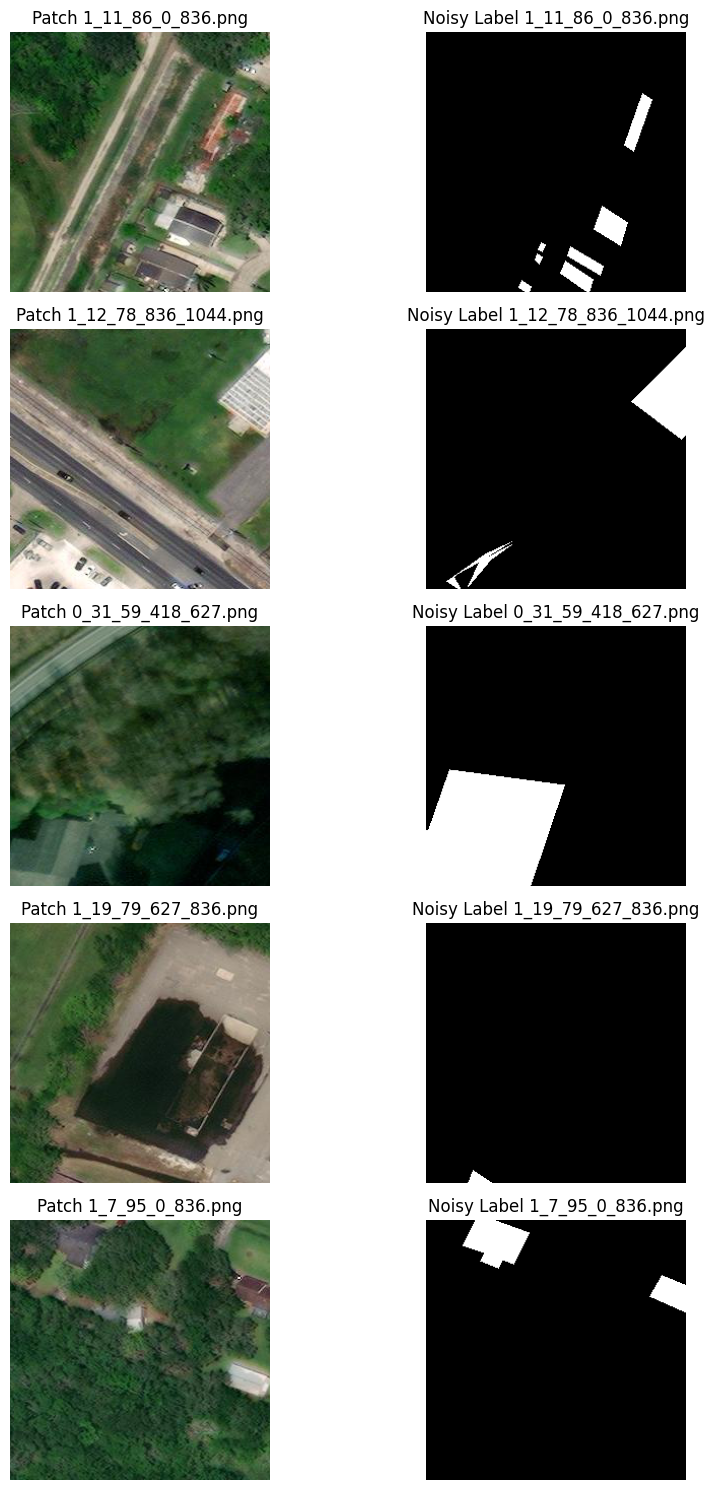

In [117]:
# Function to visualize patches and their corresponding labels
def visualize_images(data_dict, num_images=5):

    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i in range(num_images):
       
        # Load the corresponding patch and label
        patch_img = dataset[i]["image"]
        label_img = dataset[i]["label"]
        
        # Show patch
        axes[i, 0].imshow(patch_img)
        axes[i, 0].set_title(f"Patch {filtered_patch_filenames[i]}")
        axes[i, 0].axis('off')
        
        # Show noisy label (in grayscale)
        axes[i, 1].imshow(label_img, cmap='gray')
        axes[i, 1].set_title(f"Noisy Label {filtered_label_filenames[i]}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first 5 images and their corresponding noisy labels
visualize_images(dataset, num_images=5)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

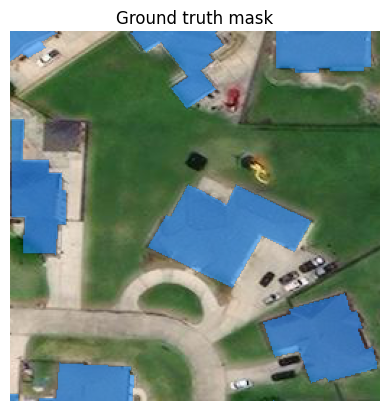

In [60]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()
image = dataset[15]["image"]
label = dataset[15]["label"]
axes.imshow(np.array(image))
ground_truth_seg = np.array(label)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [61]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [62]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [63]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [64]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [65]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [71]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [72]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([32, 3, 1024, 1024])
original_sizes torch.Size([32, 2])
reshaped_input_sizes torch.Size([32, 2])
input_boxes torch.Size([32, 1, 4])
ground_truth_mask torch.Size([32, 256, 256])


In [73]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [74]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [75]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 152/152 [5:07:45<00:00, 121.48s/it]  

EPOCH: 0
Mean loss: 0.7171211189737445


In [76]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "mito_model_checkpoint.pth")

In [77]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [78]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("mito_model_checkpoint.pth"))
     

/tmp/ipykernel_3892302/3950599981.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_mito_model.load_state_dict(torch.load("mito_model_checkpoint.pth"))


<All keys matched successfully>

In [79]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

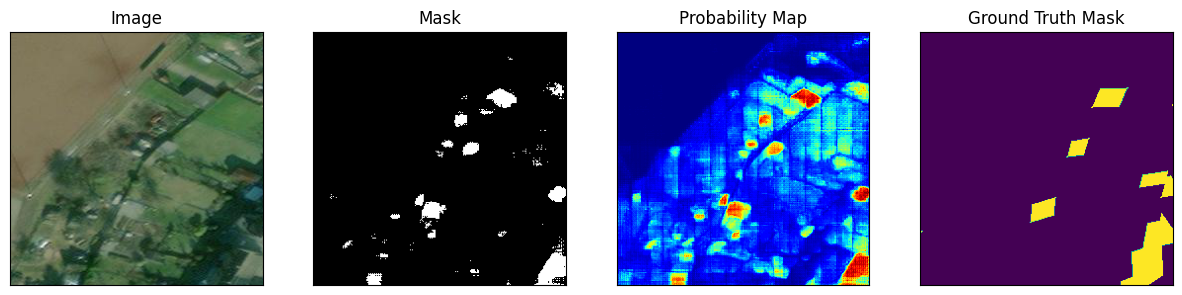

In [88]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# medsam_seg_prob = outputs.pred_masks.squeeze(1)
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))


axes[0].imshow(np.array(test_image), cmap='gray')  
axes[0].set_title("Image")

axes[1].imshow(medsam_seg, cmap='gray')  
axes[1].set_title("Mask")

axes[2].imshow(medsam_seg_prob, cmap='jet')  
axes[2].set_title("Probability Map")

axes[3].imshow(ground_truth_mask)  
axes[3].set_title("Ground Truth Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [99]:
prediction = []
for idx in tqdm(range(len(dataset))):
    test_image = dataset[idx]["image"]
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    my_mito_model.eval()

    # forward pass
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # medsam_seg_prob = outputs.pred_masks.squeeze(1)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    prediction.append(medsam_seg )

100%|██████████| 4836/4836 [5:13:50<00:00,  3.89s/it]  


In [100]:
prediction = np.array(prediction)
np.save('prediction', prediction)

In [102]:
prediction.shape

(4836, 256, 256)

In [101]:
filtered_masks.shape

(4836, 256, 256)

In [103]:
def binaryMaskIOU(mask1, mask2):   # From the question.
    mask1_area = np.count_nonzero(mask1 == 1)
    mask2_area = np.count_nonzero(mask2 == 1)
    intersection = np.count_nonzero(np.logical_and( mask1==1,  mask2==1 ))
    iou = intersection/(mask1_area+mask2_area-intersection)
    return iou

In [104]:
IOU_bucket = []
for idx in tqdm(range(len(prediction))):
    mask1=prediction[idx]
    mask2=filtered_masks[idx]
    IOU= binaryMaskIOU(mask1, mask2)
    IOU_bucket.append(IOU)

100%|██████████| 4836/4836 [00:00<00:00, 38566.70it/s]


In [107]:
len(IOU_bucket)

4836

In [108]:
IOU_bucket[0:5]

[0.2885082084225553,
 0.3547371734340573,
 0.3758162031438936,
 0.6936936936936937,
 0.5562464669304692]

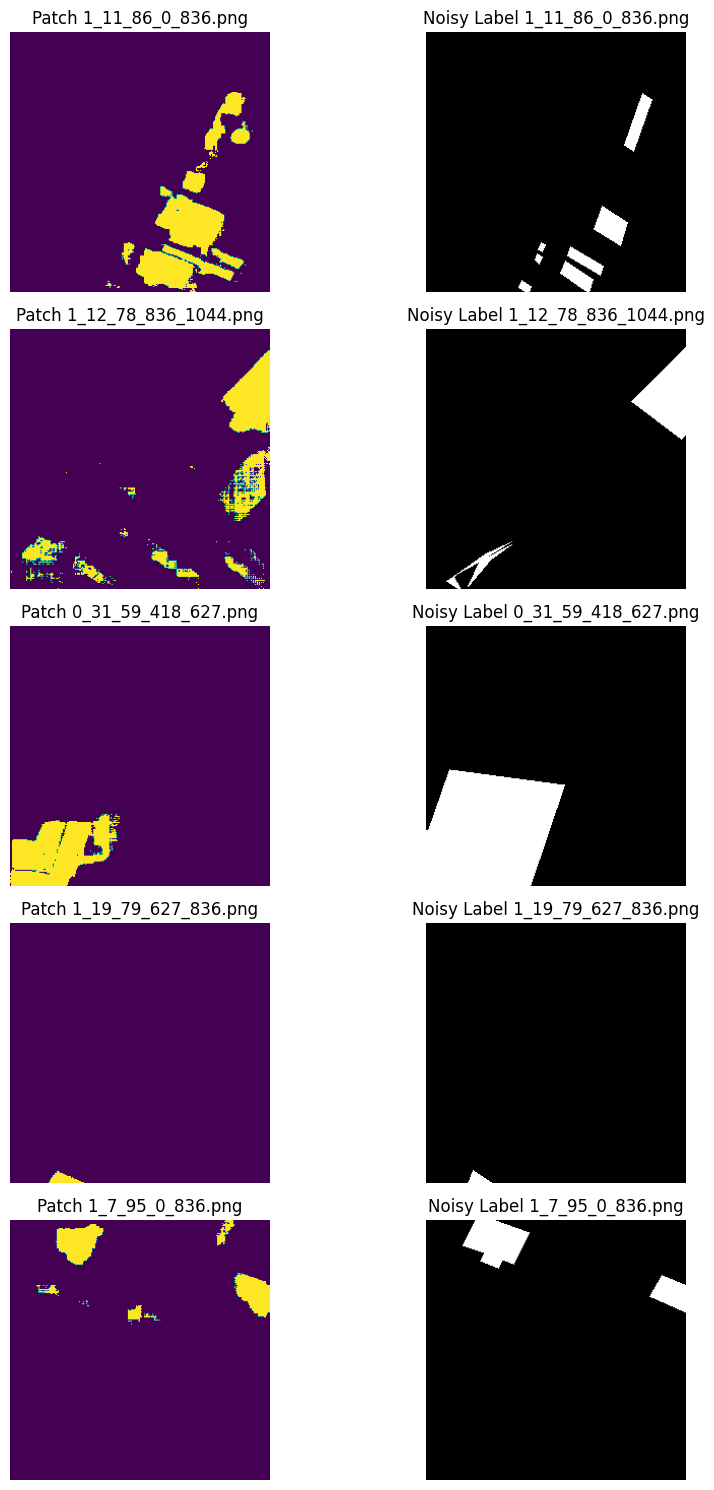

In [122]:
def visualize_images(data1, data2, num_images=5):

    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i in range(num_images):
       
        # Load the corresponding patch and label
        patch_img = data1[i]
        label_img = data2[i]
        
        # Show patch
        axes[i, 0].imshow(patch_img)
        axes[i, 0].set_title(f"Patch {filtered_patch_filenames[i]}")
        axes[i, 0].axis('off')
        
        # Show noisy label (in grayscale)
        axes[i, 1].imshow(label_img, cmap='gray')
        axes[i, 1].set_title(f"Noisy Label {filtered_label_filenames[i]}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first 5 images and their corresponding noisy labels
visualize_images(prediction, filtered_masks, num_images=5)

In [124]:
import pandas as pd

In [125]:
df = pd.DataFrame({
    'imageid': filtered_patch_filenames,
    'iou_score': IOU_bucket
})
df.head()

,filename,iou_score
0,1_11_86_0_836.png,0.288508
1,1_12_78_836_1044.png,0.354737
2,0_31_59_418_627.png,0.375816
3,1_19_79_627_836.png,0.693694
4,1_7_95_0_836.png,0.556246


In [129]:
# Sort the DataFrame by IoU score (ascending order)
df_sorted = df.sort_values(by='iou_score', ascending=False)

# Print the sorted DataFrame
print(df_sorted.head())  # To check the first few entries

                  filename  iou_score
2203  0_21_19_836_1044.png   0.978221
4672   1_18_71_627_418.png   0.952266
4457      1_8_93_0_627.png   0.947086
3071      1_5_98_836_0.png   0.944514
1316    1_8_85_627_836.png   0.944010


In [135]:
for idx in df_sorted.index.values[0:5]:
    print(idx)

2203
4672
4457
3071
1316


In [138]:
import matplotlib.pyplot as plt

def visualize_prediction_mask_filtered(index, prediction_array, mask_array, filtered_images_array):
    """
    Visualizes the predicted mask, actual mask, and filtered image side by side using the same index.
    
    Args:
    index (int): Index of the images to visualize.
    prediction_array (numpy.ndarray): Array containing the predicted masks.
    mask_array (numpy.ndarray): Array containing the actual masks (ground truth).
    filtered_images_array (numpy.ndarray): Array containing the filtered images.
    """
    
    # Get the images at the given index
    pred_img = prediction_array[index]
    mask_img = mask_array[index]
    filtered_img = filtered_images_array[index]
    
    # Create a figure with three subplots: one for prediction, one for actual mask, and one for filtered image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 3 columns, 1 row for side-by-side display
    
    # Show the predicted mask (on the left)
    ax[0].imshow(pred_img, cmap='gray')  # Assuming grayscale prediction
    ax[0].set_title('Predicted Mask')
    ax[0].axis('off')
    
    # Show the actual mask (middle)
    ax[1].imshow(mask_img, cmap='gray')  # Assuming grayscale actual mask
    ax[1].set_title('Actual Mask (Ground Truth)')
    ax[1].axis('off')
    
    # Show the filtered image (on the right)
    ax[2].imshow(filtered_img)  # Assuming RGB or grayscale filtered image
    ax[2].set_title('Filtered Image')
    ax[2].axis('off')
    
    # Display the plot
    plt.tight_layout()
    plt.show()




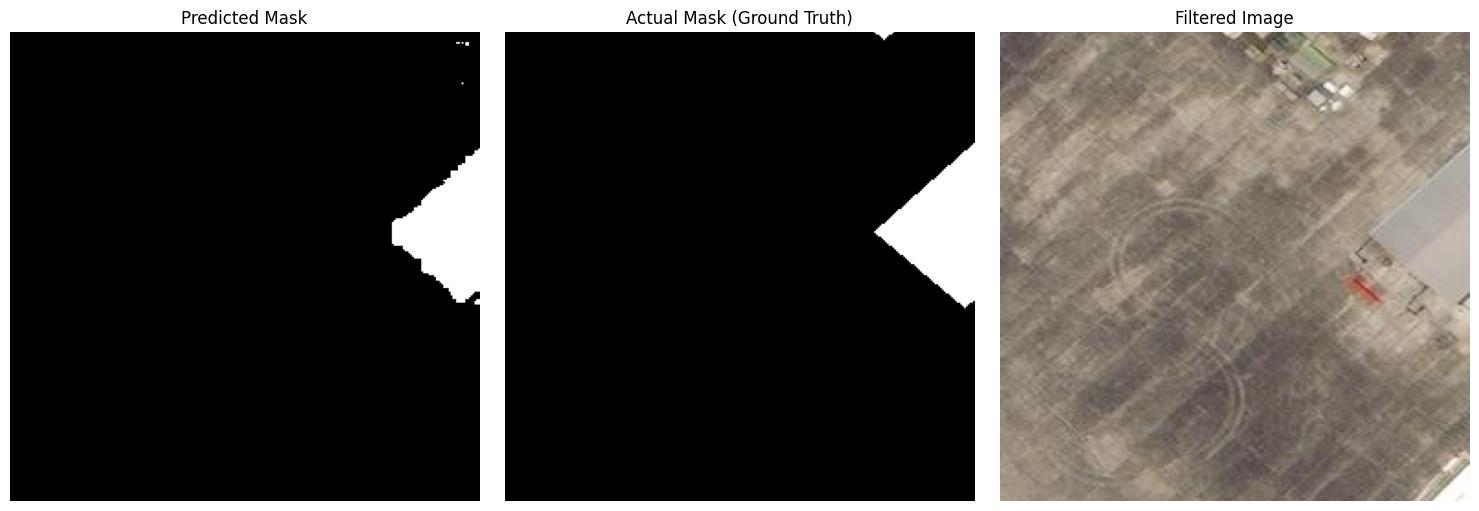

In [148]:

visualize_prediction_mask_filtered(df_sorted.index.values[50], prediction, filtered_masks, filtered_images)